Figure-SI4.ipynb
------------------------------------------------------------------------------
Purpose:  
- Generate Figure SI4 (panels A & B) illustrating representativeness across CBSA and month by various filters.

Usage:
- Change fp variable to replication filepath.
- Run all cells.
  
Requirements:
- Python 3
- Packages: matplotlib 3.9.2, pandas 2.2.2, numpy 1.26.4, scipy 1.13.0, statsmodels 0.14.1

Inputs:
- sample_statistics/sample_size_cbsa (CBSA-level sample size, produced on Spectus platform using process_trips_into_outputs_us.ipynb)
- msa/nhgis0030_ds258_2020_cbsa.csv (2020 CBSA-level populations Downloaded from NHGIS)

Outputs:
- figures/figSI4.png


In [1]:
fp = '../'
fp_input = fp + 'data/'
fp_output = fp + 'figures/'


In [2]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Helvetica'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import os
import pandas as pd
from scipy.stats import pearsonr
import statsmodels.api as sm


### Define helper functions.

In [3]:
def scatter(xcol,ycol,xname,yname,axis,color,logx=True,logy=True,fit_thresh=None,label=None,annotate=True,linecolor='black',sample_size=None):
    axis.scatter(xcol,ycol,color=color,alpha=.6,zorder=1,s=15)

    if fit_thresh:
        filterer = xcol>fit_thresh
        xcol = xcol[filterer]
        ycol = ycol[filterer]
    
    xs = np.linspace(np.min(xcol),np.max(xcol),100)

            
    if logx:
        axis.set_xscale('log')
        xcol = np.log(xcol)
    if logy:
        axis.set_yscale('log')
        ycol = np.log(ycol)
        
    r = pearsonr(xcol,ycol)
    r = np.round(r[0],3)


    mod = sm.OLS(ycol,sm.add_constant(xcol)).fit()
    beta = np.round(mod.params['total_population'],3)
    bse = np.round(mod.bse['total_population'],3)
    if logy:
        ys = [x**beta*np.exp(mod.params['const']) for x in xs]
    else:
        ys = [x*beta + mod.params['const'] for x in xs]

    axis.plot(xs,ys,color=linecolor)
    axis.grid(linestyle='dotted',zorder=0)

    axis.set_xlabel(xname)
    axis.set_ylabel(yname)

    axis.annotate(label,xy=(-0.125,1.05), xycoords='axes fraction',
                fontsize=16, fontname = 'Arial', weight='bold')

    if annotate:
 
        axis.text(x=0.1,y=.9,s=r'$\beta$ = '+f'{beta}' + r'$\pm$' + f'{bse}', transform=axis.transAxes)
        axis.text(x=0.1,y=.85,s=f'R = {r}', transform=axis.transAxes)
        if sample_size != None:
            axis.text(x=0.1,y=.8,s=f'N = {sample_size}', transform=axis.transAxes)

    else:
        return((beta,bse,r))

def read_orc(fp):
    if fp[-1] != '/':
        fp += '/'
    files = os.listdir(fp)
    dfs = []
    for file in files:
        dfs.append(pd.read_orc(fp+file))
    return pd.concat(dfs)


### Read in data.

In [4]:
sample_size_cbsa = read_orc(f'{fp_input}sample_statistics/sample_size_cbsa/')
sample_size_cbsa['users'] = sample_size_cbsa.users.astype(int)

## We exclude CBSAs in Puerto Rico due to much more limited sample sizes.
pr_cbsas=['11640','41980','10380','38660','41900']

msa_pop = pd.read_csv(f'{fp_input}msa/nhgis0030_ds258_2020_cbsa.csv')
msa_pop['home_cbsa_id'] = msa_pop.GISJOIN.str[1:]
msa_pop = msa_pop[['home_cbsa_id','U7H001']].rename(columns={'U7H001':'total_population'})

sample_size_cbsa = sample_size_cbsa[~sample_size_cbsa.home_cbsa_id.isin(pr_cbsas)]
sample_size_cbsa_mo = sample_size_cbsa.groupby(['filter','home_cbsa_id']).agg({'users':'mean'}).reset_index().merge(msa_pop)


### Create figure.

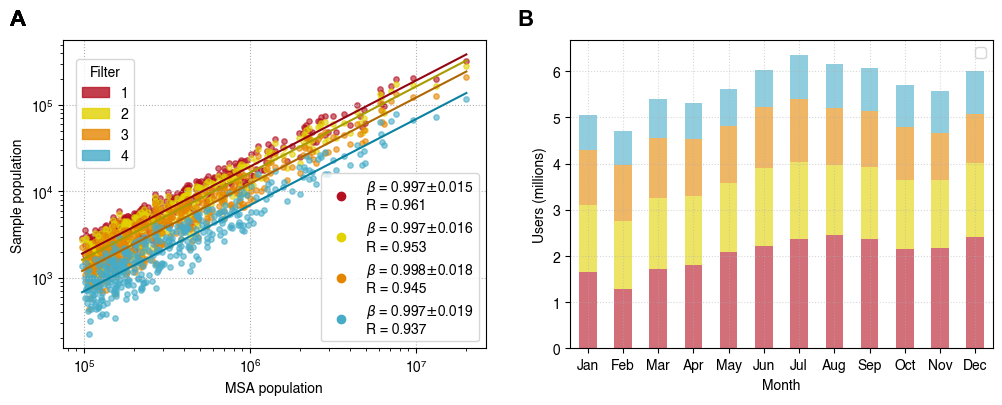

In [5]:
darkcolors=['#920513','#A79B00','#AF6703','#0A81A1']
colors = ['#B40F20','#e2d200','#E58601','#46ACC8']

fig,ax = plt.subplots(1,2,figsize=(12,4))
patches1 = []
patches2 = []

## PANEL A
for f in range(4):
    beta,bse,r = scatter(sample_size_cbsa_mo[sample_size_cbsa_mo['filter']==f+1].total_population,
            sample_size_cbsa_mo[sample_size_cbsa_mo['filter']==f+1].users,
            'MSA population',
            'Sample population',
            axis = ax[0],
            color = colors[f],
            label = 'A',
            annotate = False,
            linecolor = darkcolors[f])
    patchlab =r'$\beta$ = '+f'{beta}' + r'$\pm$' + f'{bse}'+f'\nR = {r}'
    patches1.append(Line2D([],[],color='white',markerfacecolor=colors[f],markeredgecolor=colors[f],marker='o', label=patchlab))

## PANEL B
mo_count = sample_size_cbsa.groupby(['filter','month']).agg({'users':'sum'}).reset_index()
mo_count = mo_count.pivot(index='month',columns='filter',values='users')
mo_count[0] = (mo_count[0] - mo_count[1])/1000000
mo_count[1] = (mo_count[1] - mo_count[2])/1000000
mo_count[2] = (mo_count[2] - mo_count[3])/1000000
mo_count[3] = (mo_count[3] - mo_count[4])/1000000
mo_count[4] = mo_count[4]/1000000 

mo_count[[4,3,2,1]].plot(kind='bar', stacked=True, color=[colors[0],colors[1],colors[2],colors[3]], ax=ax[1], alpha=.6, zorder=1)

## STYLE ADJUSTMENTS
ax[1].grid(linestyle='dotted', alpha=.5, zorder = -1)

ax[1].set_xlabel("Month")
ax[1].set_ylabel("Users (millions)")

ax[1].set_xticks(ticks = range(12), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation=0)
ax[1].annotate('B',xy=(-0.125,1.05), xycoords='axes fraction',
                fontsize=16, fontname = 'Arial', weight='bold')

ax[0].legend(handles=patches1, loc='lower right')
ax[1].legend([])
patch1 = mpatches.Patch(color=colors[0], alpha=.8, label='1')
patch2 = mpatches.Patch(color=colors[1], alpha=.8, label='2')
patch3 = mpatches.Patch(color=colors[2], alpha=.8, label='3')
patch4 = mpatches.Patch(color=colors[3], alpha=.8, label='4')

fig.legend(handles=[patch1,patch2,patch3,patch4], title='Filter', bbox_to_anchor=(0.19, .85))
plt.savefig(f'{fp_output}figSI4.png')